Risk - constant one as choosing A wrongfully and second as the acc
Temperature - constatnt temp
Temperature "Adaptive" - Try different temp values on the cal set and take the best (maybe use pen as val set)

Risk - As a function, try a simple model for tuning the risk

Maybe add a naive option (without google's procedure)

In [1]:
import os
SLURM_PATH = '/home/yandex/MLWG2025/amitr5'
CACHE_DIR = '' 

if SLURM_PATH in os.getcwd():
        CACHE_DIR = f'{SLURM_PATH}/tmp/hf_cache' 
        os.makedirs(CACHE_DIR, exist_ok=True)
        os.environ["PIP_PATH"] = f"{SLURM_PATH}/BaryGNN/anaconda3/envs/conf/bin/pip"
        os.environ["TEMP_DIR"] = CACHE_DIR
        os.environ["HF_HOME"] = CACHE_DIR
        os.environ["TRANSFORMERS_CACHE"] = CACHE_DIR
        os.environ["HF_DATASETS_CACHE"] = CACHE_DIR
        # Hugging Face uses HUGGINGFACE_HUB_CACHE (HF_HUB_CACHE is ignored)
        os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_DIR
        os.environ["TMPDIR"] = CACHE_DIR
        os.environ["XDG_CACHE_HOME"] = CACHE_DIR
        # os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:

# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os
import pandas as pd
# from datasets import load_dataset
# import torch.nn.functional as F
from tqdm.auto import tqdm
# Project imports #

import utils
utils.reload('utils')
from mind2web.dataloader import build_datasets_dict, subsample_by_annotation ,MultiChoiceDataset


# sys.path.append('./Mind2Web/src')

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


utils- reloaded


In [22]:
utils.reload('mind2web.dataloader')
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR, device_map="auto")
model.eval();


id2split = MultiChoiceDataset.id2split
ds_dict = build_datasets_dict(id2split.values(),cache_dir=CACHE_DIR);

mind2web.dataloader- reloaded


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [4]:
utils.reload('mind2web.dataloader')
from mind2web.dataloader import subsample_by_annotation, MultiChoiceDataset, MultiChoiceDatasetRandom
cal_dict, pen_dict, test_dict = {}, {}, {}
seed = 42
frac = 0.2
num_candidates=5
max_context_len=512

for split, test_split in ds_dict.items():
    # cal_set, test_set = subsample_by_annotation(test_split, frac=frac, seed=seed)
    # cal_set, pen_set = subsample_by_annotation(cal_set, frac=0.5, seed=seed)
    
    test_dict[split] =  MultiChoiceDataset(test_split, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)
    
    # cal_dict[split] = MultiChoiceDataset(cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True)
    
    # pen_dict[split] = MultiChoiceDataset(pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True)

    # test_dict[split] = MultiChoiceDataset(test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len,cache_prompt=True, cache_tokenized=True)

    
    # cal_dict[split] = MultiChoiceDatasetRandom(
    #     cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)
    # pen_dict[split] = MultiChoiceDatasetRandom(
    #     pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)

    # test_dict[split] = MultiChoiceDatasetRandom(
    #     test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)


mind2web.dataloader- reloaded


In [5]:
utils.reload('utils', 'mind2web.dataloader')
from utils import helpers
from mind2web import dataloader
data_df = pd.read_pickle("data_set_all.pkl")
data_df = helpers.add_eval_columns(data_df)

answers = pd.read_pickle("oracle_answers.pkl")
annotations = answers.action_uid
test_df = data_df[data_df['action_uid'].isin(annotations)]
cal_df = data_df[~data_df['action_uid'].isin(annotations)]
cal_df, pen_df = dataloader.subsample_df_by_annotation(cal_df, frac=0.5, seed=0)

utils- reloaded
mind2web.dataloader- reloaded


In [6]:

def apply_shrinkage_to_df(df, shrinkage, threshold=None, temp=1, shrinkage_type='linear'):
    df = df.copy()
    shrinkage_functions = {
        'linear': lambda x: x - np.abs(x)*shrinkage,
        'constant': lambda x: x - shrinkage,
        'CRC': lambda x: x if x > shrinkage else x - 100,
    }
    def apply_shrinkage_logits(logits_dict, shrinkage_type):
        logits = np.array([v for v in logits_dict.values()])
        # logits[0] = logits[0] - shrinkage
        # logits[0] = logits[0] - np.abs(logits[0]) * ( shrinkage)
        logits[0] = shrinkage_functions[shrinkage_type](logits[0])
        return dict(zip(logits_dict.keys(), logits))
    
    shrinkage_type = shrinkage_type if shrinkage_type in shrinkage_functions else 'constant'
    # apply_shrinkage = partial(apply_shrinkage_logits, shrinkage_type=shrinkage_type)
    df['choices_logits'] = df['choices_logits'].apply(lambda x: apply_shrinkage_logits(x, shrinkage_type=shrinkage_type))
    
    preds = df['choices_logits'].apply(lambda x: max(x, key=x.get))
    df['output_text'] = preds + df['output_text'].str[1:]
    df = utils.helpers.add_eval_columns(df, threshold=threshold, logits_temp=temp)
    return df

def get_threshold(cal_df, alpha: float):
    # google's nonconformity score
    cal_grouped = cal_df.groupby('annotation_id')
    score_per_group = 1 - cal_grouped['target_prob'].min()
    
    N = len(score_per_group)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(score_per_group.values)
    threshold = sorted_scores[k - 1]

    return threshold
risk_level = 0.05
thresh_alpha = 0.1
lambda_grid = np.linspace(0, 10.0, 1000)
best_lambda, results = utils.helpers.best_lambda_from_df(cal_df=pen_df, alpha=risk_level, lambda_grid=lambda_grid, shrinkage_type='constant')
cal_df = apply_shrinkage_to_df(cal_df, shrinkage=best_lambda, temp=1, shrinkage_type='constant')
threshold = get_threshold(cal_df, alpha=thresh_alpha)
result_df = test_df.copy()
result_df['lambda'] = best_lambda
result_df['threshold'] = threshold
result_df = apply_shrinkage_to_df(result_df, shrinkage=best_lambda, threshold=threshold, temp=1, shrinkage_type='constant')

In [31]:
utils.reload('utils.llm_utils')
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'
to_ask = result_df[result_df['pred_set_size'] > 1]
re_eval_df = utils.llm.re_evaluate_with_oracle(test_dict,  to_ask, answers, model, tokenizer, shrinkage=best_lambda)
re_eval_df.to_pickle("re_eval_results_shrinkage.pkl")

utils.llm_utils- reloaded


Re-evaluating with oracle...:   0%|          | 0/1197 [00:00<?, ?it/s]

1/1(1.00)| Improved: 0 | Worse: 0
38/101(0.38)| Improved: 2 | Worse: 5
84/201(0.42)| Improved: 7 | Worse: 12
135/301(0.45)| Improved: 11 | Worse: 21
179/401(0.45)| Improved: 16 | Worse: 23
228/501(0.46)| Improved: 21 | Worse: 27
281/601(0.47)| Improved: 25 | Worse: 35
338/701(0.48)| Improved: 26 | Worse: 41
389/801(0.49)| Improved: 30 | Worse: 51
431/901(0.48)| Improved: 32 | Worse: 59
480/1001(0.48)| Improved: 37 | Worse: 72
543/1101(0.49)| Improved: 39 | Worse: 77


In [38]:
re_eval_df[(re_eval_df['label'] != re_eval_df['pred_label']) & (re_eval_df['label'] != 'A')]

,relative_idx,annotation_id,action_uid,pred_label,pred_action,pred_value,label,label_text,choices_probs,prob,test_split,text_output
20,134,4b8fb0aa-7d7c-4a22-bfd5-f09316a050c3,660ffac3-80b3-47f2-ad88-9d1cd15878ec,F,CLICK,None,B,B. Action: CLICK,"{'B': 9.730683086672798e-05, 'F': 0.9999027252...",0.999903,0,F. Action: CLICK
25,156,c4380ce9-af36-4025-936d-354bf768c8b9,1f1f2a99-aa10-49d8-8392-47594644cdcd,F,CLICK,None,B,B. Action: CLICK,"{'B': 0.3602112829685211, 'C': 0.1071691885590...",0.387706,0,F. Action: CLICK
27,160,81b4816a-9107-4951-ae3a-6587f28b49e8,acd425d7-f9ad-4ed0-81c4-eff60c21fd48,F,CLICK,None,B,B. Action: CLICK,"{'B': 0.016711438074707985, 'C': 0.00753411976...",0.961196,0,F. Action: CLICK
40,253,94f88670-09a4-4926-9353-f5eed2d81c01,14a75133-27b4-47fb-ac61-17ba86d6cc35,F,CLICK,None,B,B. Action: SELECT Value: 1 (US$217),"{'B': 0.23092494904994965, 'C': 0.089880511164...",0.386207,0,F. Action: CLICK
41,256,b674adf9-8950-4d27-b888-b789ccd49479,f30abc11-196c-43c7-b545-aa6694449116,D,CLICK,None,B,B. Action: CLICK,"{'A': 0.05818122997879982, 'B': 0.235444411635...",0.246387,0,D. Action: CLICK
...,...,...,...,...,...,...,...,...,...,...,...,...
1178,912,6807ef3b-90d9-4592-b97f-8db60398985a,396293c3-f073-4bcc-98c8-29783e01d309,D,CLICK,None,F,F. Action: CLICK,"{'B': 0.07225283980369568, 'D': 0.586380183696...",0.586380,2,D. Action: CLICK
1182,933,7e6deaae-3391-4a43-b8d7-053dc9ba17ca,49fdf070-36c3-47d5-ae94-278a1a7f88cf,E,SELECT,6 00 p.m.,B,B. Action: SELECT Value: 6 20 p.m. – 6 40 p.m....,"{'B': 0.1338110864162445, 'C': 0.0798378586769...",0.434506,2,E. Action: SELECT Value: 6 00 p.m.
1185,941,84c1847c-a0f3-4062-b778-625578a0fba7,b0a43c6e-e108-43f7-aded-507c9dda9f4a,D,CLICK,None,E,E. Action: CLICK,"{'D': 0.5862221717834473, 'E': 0.4137778580188...",0.586222,2,D. Action: CLICK
1188,967,d10c0099-16f1-4bee-bab4-a2a143ea0fd3,751626a6-edb9-4eeb-843f-f328b6ea52b4,F,CLICK,None,B,B. Action: CLICK,"{'A': 0.0448206327855587, 'B': 0.1267427951097...",0.287050,2,F. Action: CLICK


In [40]:
re_eval_df[(re_eval_df['label'] != re_eval_df['pred_label']) & (re_eval_df['label'] != 'A')]['choices_probs']

20      {'B': 9.730683086672798e-05, 'F': 0.9999027252...
25      {'B': 0.3602112829685211, 'C': 0.1071691885590...
27      {'B': 0.016711438074707985, 'C': 0.00753411976...
40      {'B': 0.23092494904994965, 'C': 0.089880511164...
41      {'A': 0.05818122997879982, 'B': 0.235444411635...
                              ...                        
1178    {'B': 0.07225283980369568, 'D': 0.586380183696...
1182    {'B': 0.1338110864162445, 'C': 0.0798378586769...
1185    {'D': 0.5862221717834473, 'E': 0.4137778580188...
1188    {'A': 0.0448206327855587, 'B': 0.1267427951097...
1191    {'A': 0.10796152800321579, 'B': 0.093450427055...
Name: choices_probs, Length: 362, dtype: object

In [1]:
utils.reload('utils.helpers')
cal_df = pd.read_pickle('cal_df.pkl')
cal_df = utils.helpers.add_eval_columns(cal_df)
label_map = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}
y_cal = cal_df["target_label"].map(label_map)

alpha = 0.1
lambda_grid = np.linspace(0.0, 1.0, 2000)

best_lambda, results = utils.helpers.tune_lambda_group_risk(
    cal_df=cal_df,
    y_cal=y_cal,
    alpha=alpha,
    lambda_grid=lambda_grid,
)

best = results[best_lambda]
best, best_lambda

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


NameError: name 'utils' is not defined

In [251]:
utils.reload('utils.helpers')
utils.reload('mind2web.dataloader')
utils.reload('utils.llm_utils')

# full_df = pd.read_pickle('data_set_all.pkl')
# full_df["test_split"] = full_df["test_split"].astype(str)
# cal_dict
# df = utils.helpers.filter_to_calibration_actions(full_df, cal_dict)

utils.helpers- reloaded
mind2web.dataloader- reloaded
utils.llm_utils- reloaded


In [236]:
def get_threshold(cal_df, alpha: float):
    # google's nonconformity score
    cal_grouped = cal_df.groupby('annotation_id')
    score_per_group = 1 - cal_grouped['target_prob'].min()
    
    N = len(score_per_group)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(score_per_group.values)
    threshold = sorted_scores[k - 1]
    return threshold


def split_to_cal_penalty(cal_set, seed=0):
    cal_set, pen_set = subsample_by_annotation(cal_set, frac=0.5, seed=seed)
    cal_dict[split] = MultiChoiceDataset(
        cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )
    pen_dict[split] = MultiChoiceDataset(
        pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )

    return cal_dict, pen_dict

def evaluation(cal_set, test_dict, full_df, model, tokenizer, seed=0):
    
    eval_to = 'crc'

    full_df["test_split"] = full_df["test_split"].astype(str)
    cal_dict, pen_dict = split_to_cal_penalty(cal_set, seed=seed)
    # cal_df = utils.helpers.filter_to_calibration_actions(full_df, cal_dict)
    pen_df = utils.helpers.filter_to_calibration_actions(full_df, pen_dict)
    best_lambda, results = utils.helpers.best_lambda_from_df(cal_df=pen_df, alpha=0.2)
    pen_df['lambda'] = best_lambda
    pen_df = utils.helpers.add_eval_columns(pen_df, to_save=True, save_path=f'{eval_to}/pen/pen_{seed}.pkl')

    cal_df = utils.llm.evaluate_splits(cal_dict, model, tokenizer, shrinkage=best_lambda)
    cal_df['lambda'] = best_lambda
    cal_df = utils.helpers.add_eval_columns(cal_df, to_save=True, save_path=f'{eval_to}/cal/cal_{seed}.pkl')
    
    threshold = get_threshold(cal_df, alpha=0.1)
    result_df = utils.llm.evaluate_splits(test_dict, model, tokenizer, shrinkage=best_lambda)
    result_df['lambda'] = best_lambda
    result_df['threshold'] = threshold
    result_df = utils.helpers.add_eval_columns(result_df, threshold=threshold, to_save=True, save_path=f'{eval_to}/test/test_{seed}.pkl')
    return result_df

    

In [288]:
cal_dict2 = {}
for split, cal_set in ds_dict.items():
    cal_dict2[split] = MultiChoiceDatasetRandom(
            cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, top_k=10)

cal_df2 = utils.llm.evaluate_splits(cal_dict2, model, tokenizer, shrinkage=0.7237237237237237,num_iterations=3)


Evaluating split: test_task


/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (125915272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (125915272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (125915272 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Evaluating split: test_domain


--- Logging error ---
Traceback (most recent call last):
  File "/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/logging/__init__.py", line 1155, in emit
  File "/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/logging/__init__.py", line 1137, in flush
    self.stream.flush()
    ~~~~~~~~~~~~~~~~~^^
OSError: [Errno 5] Input/output error
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop

Evaluating split: test_website


Threshold: 0.9999990176304436,187


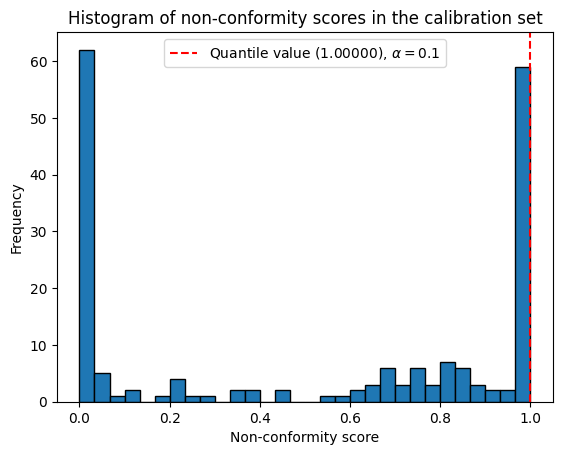

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


In [ ]:
# results
cal_df = pd.read_pickle('results/crc/cal/cal_0.pkl')
pen_df = pd.read_pickle('results/crc/pen/pen_0.pkl')
test_df = pd.read_pickle('results/crc/test/test_0.pkl')

cal_df = utils.helpers.add_eval_columns(cal_df, logits_temp=1, to_save=False)

threshold = get_threshold(cal_df, alpha=0.1)
cal_grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - cal_grouped['target_prob'].min()
print(f'Threshold: {threshold},{len(score_per_group)}')
utils.plot.nonconformity_histogram(score_per_group, threshold=threshold)

In [283]:
test_df = utils.helpers.add_eval_columns(test_df, threshold=threshold, logits_temp=1, to_save=False)
print(test_df['pred_set_size'].mean())
best_lambda, results = utils.helpers.best_lambda_from_df(cal_df=pen_df)
best_lambda

1.8562197092084007


0.7237237237237237

In [281]:
test_df.head()

test_df['pred_label'].value_counts()
# cal_df['pred_label'].value_counts()
# pen_df['pred_label'].value_counts()
# test_df['correct'].mean()
# utils.plot.nonconformity_histogram(score_per_group, threshold)

pred_label
B    453
F    137
C     11
D     10
E      8
Name: count, dtype: int64

0.8723747980613893
0.8723747980613893


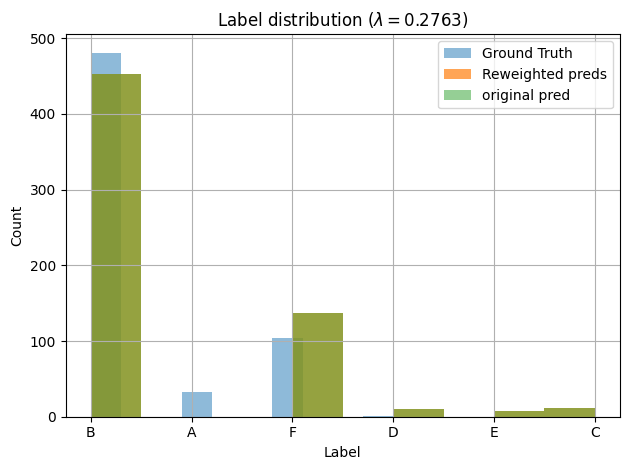

In [275]:
import matplotlib.pyplot as plt
# pen_df = utils.helpers.add_eval_columns(pen_df)
logits = test_df['choices_logits'].apply(lambda x: list(x.values()))
logits = np.array(logits.tolist()).reshape(-1, 6) # 6 = A,.., F
logits += np.abs(logits.min(axis=1).reshape(-1,1))
logits[:,0] = logits[:,0] * (1-best_lambda) #(1 - 0.84)

preds_raw = logits.argmax(axis=1) + 65
preds = [chr(x) for x in preds_raw]
print((preds == test_df['target_label']).mean())
print(test_df['correct'].mean())


preds_df = pd.DataFrame(preds, columns=['pred'])
preds_df['correct'] = (preds_df['pred'] == test_df['target_label'])
preds_df[preds_df['correct'] == False].value_counts()


test_df['target_label'].hist(alpha=0.5, label='Ground Truth')
preds_df['pred'].hist(alpha=0.7, label='Reweighted preds')
test_df['pred_label'].hist(alpha=0.5, label='original pred')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title(rf'Label distribution ($\lambda = {1-best_lambda:.4f}$)')
plt.legend()
plt.tight_layout()



In [61]:
# out['scores'][0].shape
out['scores'][3].shape

torch.Size([1, 32128])

In [292]:
cal_df2 = utils.helpers.add_eval_columns(cal_df2)
cal_df2['pred_label'].value_counts()

pred_label
B    12537
F     3861
C     1380
D      798
E      660
Name: count, dtype: int64

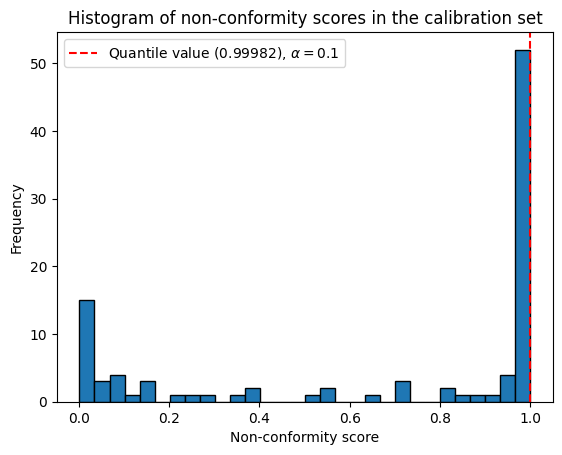

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


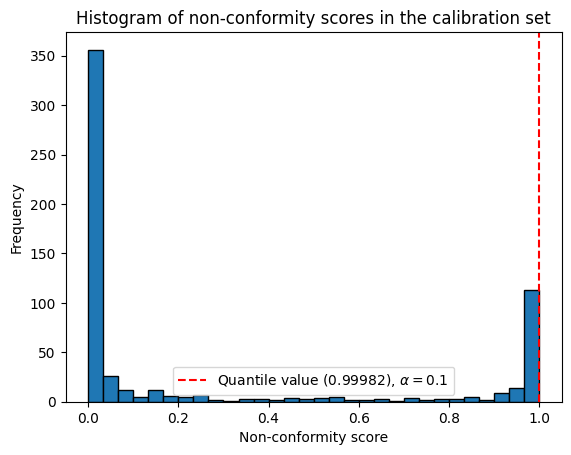

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


In [118]:
utils.plot.nonconformity_histogram(score_per_group, threshold)
utils.plot.nonconformity_histogram(1-cal_df['true_prob'], threshold)